In [1]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [2]:
# Read in raw data files
df_train = pd.read_csv('./datasets/credit_train.csv')
df_test = pd.read_csv('./datasets/credit_test.csv')

In [3]:
# Concatenate raw data files into one dataframe
df = pd.concat([df_train, df_test])

In [4]:
# Remove rows which are completely null from dataframe
df = df[df.isnull().sum(axis=1) < df.shape[1]]

In [5]:
# Replace invalid credit scores (above 850 with an extra 0 entered) with credit score 10X smaller
df['Credit Score'] = np.where(df['Credit Score'] > 850, df['Credit Score']/10, df['Credit Score'])

In [6]:
# Drop rows with contaminated credit score (invalid credit score value)
df = df[df['Credit Score'] <= 850]
df = df.reset_index(drop=True)

In [7]:
# Preview dataframe
df

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
2,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
3,89d8cb0c-e5c2-4f54-b056-48a645c543dd,4ffe99d3-7f2a-44db-afc1-40943f1f9750,Charged Off,206602.0,Short Term,729.0,896857.0,10+ years,Home Mortgage,Debt Consolidation,16367.74,17.3,NaN,6.0,0.0,215308.0,272448.0,0.0,0.0
4,273581de-85d8-4332-81a5-19b04ce68666,90a75dde-34d5-419c-90dc-1e58b04b3e35,Fully Paid,217646.0,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,272052.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88860,a2701102-3cb0-46a6-8658-e6f20d950182,6dc5fa63-93f4-43a9-8192-2df57548287b,NaN,442596.0,Short Term,739.0,1528968.0,7 years,Home Mortgage,Debt Consolidation,19494.38,16.7,79.0,11.0,0.0,419235.0,656876.0,0.0,0.0
88861,c4ab66f9-833c-43b8-879c-4f8bcb64dd14,8ee2002b-8fb6-4af0-ab74-25a1c23e7647,NaN,157806.0,Short Term,731.0,1514376.0,6 years,Rent,Debt Consolidation,4795.41,12.5,NaN,9.0,0.0,87058.0,234410.0,0.0,0.0
88862,bbd3a392-01b4-4e0e-9c28-b2a4a39beac7,6c306306-f5c2-4db5-b74a-af2895123ecb,NaN,132550.0,Short Term,718.0,763192.0,4 years,Home Mortgage,Debt Consolidation,12401.87,9.9,20.0,8.0,0.0,74309.0,329692.0,0.0,0.0
88863,0cc8e0e0-1bc6-49d7-ad0f-0598b647458f,f90cf410-a34b-49e7-8af9-2b405e17b827,NaN,99999999.0,Short Term,721.0,972097.0,10+ years,Home Mortgage,Debt Consolidation,12232.20,16.8,24.0,8.0,1.0,184984.0,240658.0,0.0,0.0


In [8]:
# Preview dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88865 entries, 0 to 88864
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88865 non-null  object 
 1   Customer ID                   88865 non-null  object 
 2   Loan Status                   80846 non-null  object 
 3   Current Loan Amount           88865 non-null  float64
 4   Term                          88865 non-null  object 
 5   Credit Score                  88865 non-null  float64
 6   Annual Income                 88865 non-null  float64
 7   Years in current job          85111 non-null  object 
 8   Home Ownership                88865 non-null  object 
 9   Purpose                       88865 non-null  object 
 10  Monthly Debt                  88865 non-null  float64
 11  Years of Credit History       88865 non-null  float64
 12  Months since last delinquent  41930 non-null  float64
 13  N

In [9]:
# See how many missing values per column
df.isna().sum()/len(df)

Loan ID                         0.000000
Customer ID                     0.000000
Loan Status                     0.090238
Current Loan Amount             0.000000
Term                            0.000000
Credit Score                    0.000000
Annual Income                   0.000000
Years in current job            0.042244
Home Ownership                  0.000000
Purpose                         0.000000
Monthly Debt                    0.000000
Years of Credit History         0.000000
Months since last delinquent    0.528161
Number of Open Accounts         0.000000
Number of Credit Problems       0.000000
Current Credit Balance          0.000000
Maximum Open Credit             0.000011
Bankruptcies                    0.002037
Tax Liens                       0.000079
dtype: float64

In [10]:
#fill in missing values with zero and observe distribution 
df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)

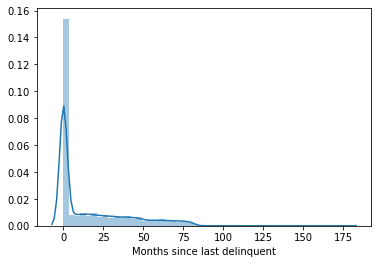

In [11]:
import seaborn as sns
sns.distplot(df['Months since last delinquent'])

In [12]:
#from the plot, we can divdie Months since last delinquent into following categories:
#0: no delinquent, 0~25: 2 years, 25~50: 4 years, 50 ~75: 6 years, >75: over 6 years
df['Delinquent Time'] = 0
df.loc[(df['Months since last delinquent'] == 0), 'Delinquent Time'] = 0
df.loc[(df['Months since last delinquent']>0)&(df['Months since last delinquent']<= 25),'Delinquent Time'] = 2
df.loc[(df['Months since last delinquent']>25)&(df['Months since last delinquent']<= 50),'Delinquent Time'] = 4
df.loc[(df['Months since last delinquent']>50)&(df['Months since last delinquent']<= 75),'Delinquent Time'] = 6
df.loc[(df['Months since last delinquent']>75),'Delinquent Time'] = 6

In [13]:
to_drop = 'Months since last delinquent'
df = df.drop(to_drop, axis = 1)

In [14]:
# Impute missing values for numerical data with the mean except bankruptcies and years in current job 
numeric = df.select_dtypes('number')
numeric.drop(columns = 'Bankruptcies')
numeric_cols = numeric.columns
df[numeric.columns] = numeric.fillna(numeric.mean())

In [15]:
#fill bankruptcies NaN value with 0 
df['Bankruptcies'] = df['Bankruptcies'].fillna(0)

In [16]:
# Impute missing values for categorical data with the mode
categoric = df.select_dtypes('object')
categoric = categoric.drop(columns = 'Years in current job')
df[categoric.columns] = categoric.fillna(categoric.agg(lambda x: x.mode().values[0]))

In [17]:
#fill NaN for Years in current job with'< 1 year'
df['Years in current job'] = df['Years in current job'].fillna('< 1 year')

In [18]:
# Confirm all missing values have been filled in
df.isna().sum()

Loan ID                      0
Customer ID                  0
Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Annual Income                0
Years in current job         0
Home Ownership               0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          0
Bankruptcies                 0
Tax Liens                    0
Delinquent Time              0
dtype: int64

In [19]:
# Check unique values for each column
df.nunique()

Loan ID                      72344
Customer ID                  72344
Loan Status                      2
Current Loan Amount          21046
Term                             2
Credit Score                   167
Annual Income                37853
Years in current job            11
Home Ownership                   4
Purpose                         16
Monthly Debt                 59476
Years of Credit History        501
Number of Open Accounts         51
Number of Credit Problems       14
Current Credit Balance       30994
Maximum Open Credit          41585
Bankruptcies                     9
Tax Liens                       14
Delinquent Time                  4
dtype: int64

In [20]:
# Check unique values for each categorical column
df[categoric.columns].nunique()

Loan ID           72344
Customer ID       72344
Loan Status           2
Term                  2
Home Ownership        4
Purpose              16
dtype: int64

In [21]:
# Label encode categorical columns
le = LabelEncoder()
df[categoric.columns] = df[categoric.columns].apply(le.fit_transform)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Delinquent Time
0,5898,43043,1,445412.0,1,709.0,1167493.0,8 years,1,5,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0,0
1,22377,26873,1,99999999.0,1,741.0,2231892.0,8 years,2,3,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0,4
2,33793,65397,1,347666.0,0,721.0,806949.0,3 years,2,3,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0
3,39047,22612,0,206602.0,1,729.0,896857.0,10+ years,1,3,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0,0
4,11116,40916,1,217646.0,1,730.0,1184194.0,< 1 year,1,3,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0,2


In [22]:
# Convert 'Years in current job' to numerical column - 
# Note: Numerical tranformation converts '< 1 year' to 0 and '10+ years' to 10 for simplicity
df['Years in current job'] = df['Years in current job'].replace({'< 1 year':0, '1 year': 1, '2 years': 2,
                                                                 '3 years':3, '4 years':4, '5 years':5, 
                                                                 '6 years':6, '7 years':7, '8 years':8,
                                                                 '9 years': 9, '10+ years': 10})
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Delinquent Time
0,5898,43043,1,445412.0,1,709.0,1167493.0,8,1,5,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0,0
1,22377,26873,1,99999999.0,1,741.0,2231892.0,8,2,3,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0,4
2,33793,65397,1,347666.0,0,721.0,806949.0,3,2,3,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0
3,39047,22612,0,206602.0,1,729.0,896857.0,10,1,3,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0,0
4,11116,40916,1,217646.0,1,730.0,1184194.0,0,1,3,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0,2


In [23]:
# Get more insight into 'Credit Score' column
df['Credit Score'].describe()

count    88865.000000
mean       716.323930
std         28.291419
min        585.000000
25%        703.000000
50%        722.000000
75%        739.000000
max        751.000000
Name: Credit Score, dtype: float64

In [24]:
# Add 'Credit Score Range' column
df['Credit Score Range'] = pd.cut(df['Credit Score'], 10)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Delinquent Time,Credit Score Range
0,5898,43043,1,445412.0,1,709.0,1167493.0,8,1,5,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0,0,"(701.2, 717.8]"
1,22377,26873,1,99999999.0,1,741.0,2231892.0,8,2,3,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0,4,"(734.4, 751.0]"
2,33793,65397,1,347666.0,0,721.0,806949.0,3,2,3,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0,"(717.8, 734.4]"
3,39047,22612,0,206602.0,1,729.0,896857.0,10,1,3,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0,0,"(717.8, 734.4]"
4,11116,40916,1,217646.0,1,730.0,1184194.0,0,1,3,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0,2,"(717.8, 734.4]"


Class=(584.834, 601.6], n=268 (0.302%)
Class=(601.6, 618.2], n=505 (0.568%)
Class=(618.2, 634.8], n=821 (0.924%)
Class=(634.8, 651.4], n=1606 (1.807%)
Class=(651.4, 668.0], n=3157 (3.553%)
Class=(668.0, 684.6], n=5127 (5.769%)
Class=(684.6, 701.2], n=9401 (10.579%)
Class=(701.2, 717.8], n=16553 (18.627%)
Class=(717.8, 734.4], n=23062 (25.952%)
Class=(734.4, 751.0], n=28365 (31.919%)


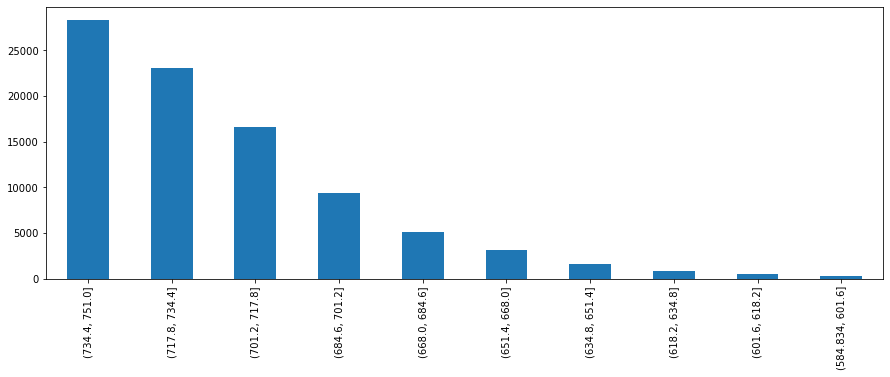

In [30]:
from collections import Counter
counted_target = Counter(df['Credit Score Range'])
for Range, rangeAmount in sorted(counted_target.items()):
    percentage = rangeAmount / len(df['Credit Score Range']) * 100
    print('Class=%s, n=%d (%.3f%%)' % (Range, rangeAmount, percentage))
df['Credit Score Range'].value_counts().plot(kind='bar',figsize=(15,5))

In [26]:
# Normalize continuous columns
numeric = df.select_dtypes('number')
transformer = preprocessing.MinMaxScaler()
numeric_normalized = transformer.fit_transform(numeric.values)
df[numeric.columns] = numeric_normalized

In [27]:
# View final dataframe after processing
df

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Delinquent Time,Credit Score Range
0,0.081528,0.594985,1.0,0.004342,1.0,0.746988,0.006592,0.8,0.333333,0.333333,0.011965,0.202096,0.066667,0.066667,0.006940,0.000271,0.142857,0.0,0.000000,"(701.2, 717.8]"
1,0.309318,0.371466,1.0,1.000000,1.0,0.939759,0.013024,0.8,0.666667,0.200000,0.066998,0.167665,0.226667,0.066667,0.009063,0.000487,0.000000,0.0,0.666667,"(734.4, 751.0]"
2,0.467122,0.903985,1.0,0.003365,0.0,0.819277,0.004413,0.3,0.666667,0.200000,0.020057,0.124251,0.106667,0.000000,0.007796,0.000251,0.000000,0.0,0.000000,"(717.8, 734.4]"
3,0.539748,0.312567,0.0,0.001954,1.0,0.867470,0.004957,1.0,0.333333,0.200000,0.037554,0.203593,0.066667,0.000000,0.006549,0.000177,0.000000,0.0,0.000000,"(717.8, 734.4]"
4,0.153657,0.565583,1.0,0.002064,1.0,0.873494,0.006693,0.0,0.333333,0.200000,0.024906,0.238024,0.160000,0.066667,0.003716,0.000177,0.142857,0.0,0.333333,"(717.8, 734.4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88860,0.635777,0.429482,1.0,0.004314,1.0,0.927711,0.008776,0.7,0.333333,0.200000,0.044728,0.194611,0.133333,0.000000,0.012751,0.000427,0.000000,0.0,1.000000,"(734.4, 751.0]"
88861,0.769598,0.558257,1.0,0.001466,1.0,0.879518,0.008688,0.6,1.000000,0.200000,0.011003,0.131737,0.106667,0.000000,0.002648,0.000152,0.000000,0.0,0.000000,"(717.8, 734.4]"
88862,0.734902,0.423828,1.0,0.001213,1.0,0.801205,0.004149,0.4,0.333333,0.200000,0.028455,0.092814,0.093333,0.000000,0.002260,0.000214,0.000000,0.0,0.333333,"(717.8, 734.4]"
88863,0.050081,0.972796,1.0,1.000000,1.0,0.819277,0.005411,1.0,0.333333,0.200000,0.028066,0.196108,0.093333,0.066667,0.005626,0.000156,0.000000,0.0,0.333333,"(717.8, 734.4]"


In [28]:
# Write processed dataframe to csv file called 'credit.csv'
df.to_csv('./datasets/credit.csv', index=False)